<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [325]:
pip install pygam

In [326]:
pip install graphviz

In [327]:
import numpy as np
import pandas as pd        
from pygam import LogisticGAM
from matplotlib import pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_recall_curve) 
from sklearn.model_selection import train_test_split
import pymc3 as pm
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [328]:
df = pd.read_csv('overloadlog.csv')
#df = df.assign(const=1)
X = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN']] ## Predictors
X = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN','CEN_min','NES_min','NOR_min','NTE_min','OCC_min','ORI_min','PEN_min']] ## Predictors
y = df['L3']

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 5)
#X_train.describe()

In [329]:
#sns.set_theme(style = "ticks")
#sns.set(font_scale = 1.6)
#sns.pairplot(X_train)

## Regresión logística con la librería statsmodel.

In [330]:
model = sm.Logit(y_train, X_train)
results = model.fit()
logit_result_prediction = results.predict(X_test)
print(results.summary())
#convert y_score into binary decisions    
y_pred = [1 if x > 0.5 else 0 for x in logit_result_prediction]

Optimization terminated successfully.
         Current function value: 0.319190
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                     L3   No. Observations:                  100
Model:                          Logit   Df Residuals:                       86
Method:                           MLE   Df Model:                           13
Date:                Wed, 02 Mar 2022   Pseudo R-squ.:                  0.5395
Time:                        05:57:34   Log-Likelihood:                -31.919
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 1.041e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CEN           19.2307     43.308      0.444      0.657     -65.651     104.112
NES            4.0356     17

In [331]:
# Exactitud del modelo
print('Test accuracy RegLogit = ', accuracy_score(y_test, y_pred))

# Compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, y_pred)
print(confussion_matrix)

Test accuracy RegLogit =  0.7531914893617021
[[79 17]
 [41 98]]


## Regresión logística con la librería statsmodel con stepwise

In [332]:
# Se ordenan los valores p y se selecciona el más pequeño
p_values = results.pvalues.sort_values(ascending = False)
pmenor = p_values.head(1)

print("menor PI:  ", pmenor.item())

## Proceso de stepwise
while pmenor.item() > 0.005:
    print(pmenor.index.tolist())
    X_train = X_train.drop(pmenor.index.tolist(), axis=1)
    model = sm.Logit(y_train, X_train)
    model = model.fit()
    # Se ordenan los valores p y se selecciona el más pequeño
    p_values = model.pvalues.sort_values(ascending = False)
    pmenor = p_values.head(1)

print(model.summary())

menor PI:   0.81997152760058
['NES']
Optimization terminated successfully.
         Current function value: 0.319443
         Iterations 10
['CEN_min']
Optimization terminated successfully.
         Current function value: 0.319602
         Iterations 10
['ORI']
Optimization terminated successfully.
         Current function value: 0.320523
         Iterations 10
['CEN']
Optimization terminated successfully.
         Current function value: 0.321918
         Iterations 10
['NOR_min']
Optimization terminated successfully.
         Current function value: 0.323687
         Iterations 10
['NES_min']
Optimization terminated successfully.
         Current function value: 0.328325
         Iterations 9
['PEN']
Optimization terminated successfully.
         Current function value: 0.331529
         Iterations 9
['ORI_min']
Optimization terminated successfully.
         Current function value: 0.348176
         Iterations 9
['NTE_min']
Optimization terminated successfully.
         Current fun

In [333]:
column     = list(X_train.columns)
y_pred       = model.predict(X_test[column])

#prediction = list(map(round, y_pred))
#convert y_score into binary decisions    
y_pred = [1 if x > 0.5 else 0 for x in y_pred]

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm)
 
# Exactitud del modelo
print('Test accuracy = ', accuracy_score(y_test, y_pred))

Confusion Matrix : 
 [[ 65  31]
 [ 23 116]]
Test accuracy =  0.7702127659574468


## Regresión lógistica aditiva generalizada (GAM) 

In [334]:
X = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN','CEN_min','NES_min','NOR_min','NTE_min','OCC_min','ORI_min','PEN_min']] ## Predictors
y = df['L3']

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 5)

In [335]:
# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X_train.columns
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
#vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.values.shape[1])]

column = vif["VIF"]
max_value = column.max()
indx = vif[vif['VIF'] == max_value].index

print(indx.values[0])

X_train.drop(X_train.columns[indx.values[0]], axis=1, inplace=True)
column  = X_train.columns

#Fit a GAM
gam = LogisticGAM(max_iter=100, tol=0.1, verbose=True).fit(X_train, y_train)

0


/usr/local/lib/python3.7/dist-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


did not converge


In [336]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      6.3662
Link Function:                        LogitLink Log Likelihood:                                   -45.4298
Number of Samples:                          100 AIC:                                              103.5918
                                                AICc:                                             104.9369
                                                UBRE:                                               3.0868
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3446
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [337]:
# Exactitud del modelo
print('Test accuracy GAM = ', accuracy_score(y_test, gam.predict(X_test[column])))
#compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, gam.predict(X_test[column]))
print(confussion_matrix)

Test accuracy GAM =  0.7829787234042553
[[ 64  32]
 [ 19 120]]


<Figure size 432x288 with 0 Axes>

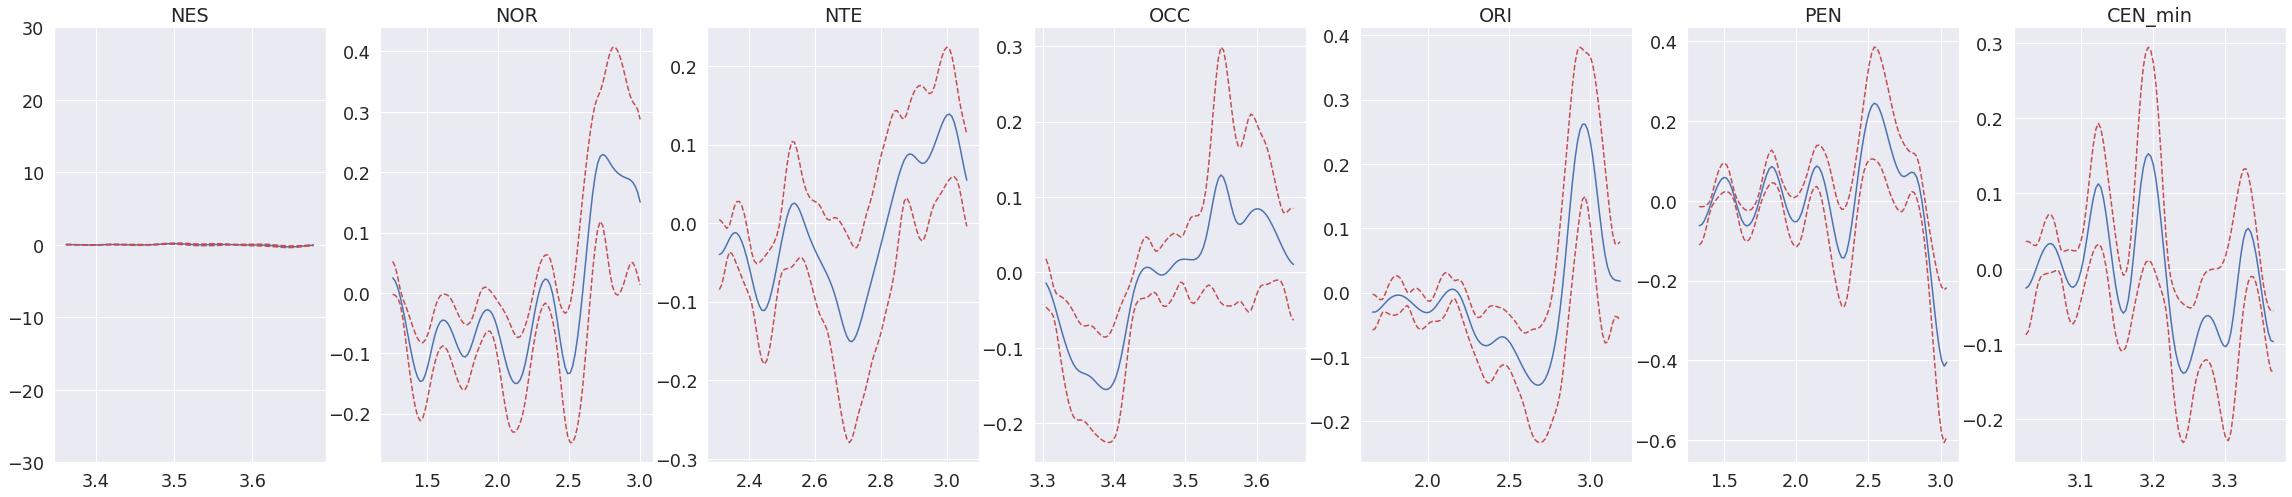

In [338]:
titles = X_test[column].columns[0:8]
plt.figure()
fig, axs = plt.subplots(1, 7, figsize=(40, 8))

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])
        
plt.show()

## Árboles de decisión

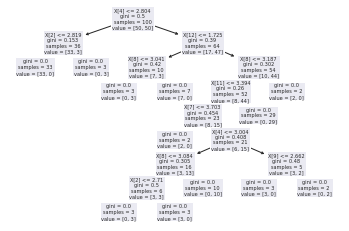

In [339]:
from sklearn import datasets, metrics, model_selection, svm
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_leaf_nodes=40)
clf = clf.fit(X_train[column], y_train)
tree.plot_tree(clf)
#metrics.plot_roc_curve(clf, X_test, y_test) 
plt.show()

In [340]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("overload") 

'overload.pdf'

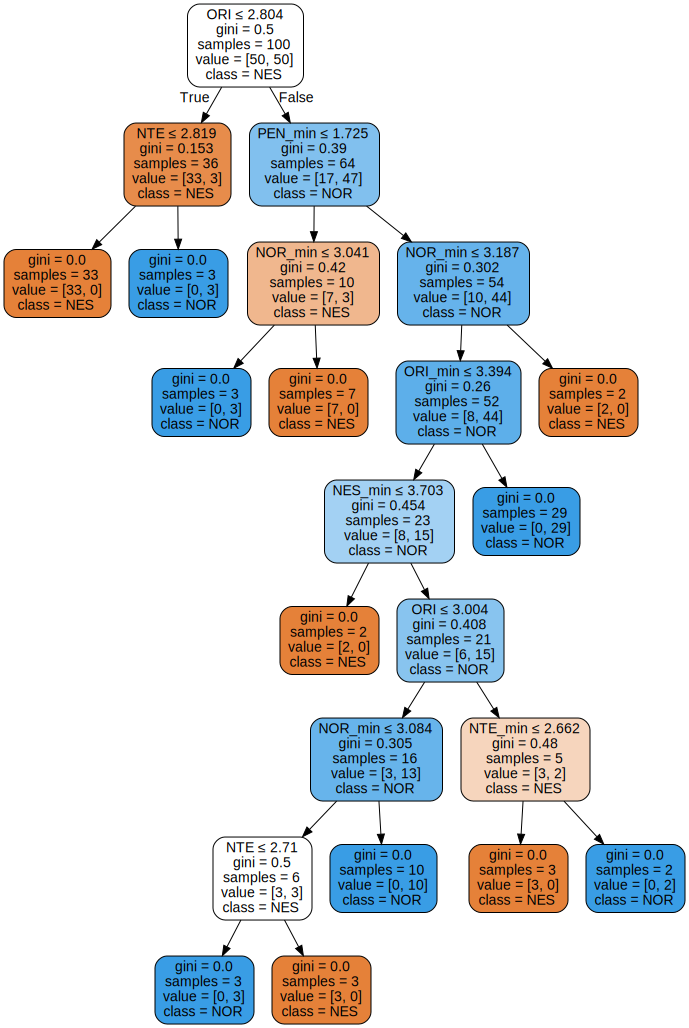

In [341]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_test[column].columns.values.tolist(),
                                class_names=X_test[column].columns.values.tolist(),
                                filled=True, 
                                rounded=True, 
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [342]:
# Exactitud del modelo
print('Test accuracy árbol = ', accuracy_score(y_test, clf.predict(X_test[column])))

#compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, clf.predict(X_test[column]))
print(confussion_matrix)

Test accuracy árbol =  0.7276595744680852
[[76 20]
 [44 95]]


[Doc LogisticGAM](https://pygam.readthedocs.io/en/latest/api/logisticgam.html)

[A Tour of pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html)

[A example of pyGAM](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)

[documentación pyGAM](https://pygam.readthedocs.io/en/latest/)

[pyGAM : Getting Started with Generalized Additive Models in Python](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)

[Building interpretable models with Generalized additive models in Python](https://medium.com/just-another-data-scientist/building-interpretable-models-with-generalized-additive-models-in-python-c4404eaf5515)

[Scikit Decision Trees](https://scikit-learn.org/stable/modules/tree.html)

[Post pruning decision trees with cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)

[Understanding the decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)